In [1]:
from __future__ import print_function

import argparse
import csv
import os
import os.path
import shutil
import time
import matplotlib.pyplot as plt
import numpy
from random import shuffle
%matplotlib inline

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

import glob
import cv2

# The module also provides a number of factory functions, 
# including functions to load images from files, and to create new images.
from PIL import Image

# Load Data Class

In [2]:
class DatasetCatDog(data.Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in os.listdir(root):
            if filename.endswith('jpg'):
                images.append('{}'.format(filename))

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [3]:
!pwd

/home/aims/Dog-Cat-Classifier


In [4]:
path = '/home/aims/Documents/AMMI-tutorials/Pytorch/Dog_Cat_Classifier/train'
data = DatasetCatDog(path)

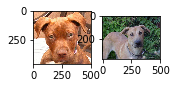

In [5]:
# show some images
plt.figure()
for i in range(2):
    plt.subplot(2, 5, i + 1)
    image, name = data.__getitem__(i)
    #print(name)
    #image.show()
    plt.imshow(image)

In [6]:
train_path = path + '/*.jpg'
# read addresses and labels from the 'train' folder
addrs = glob.glob(train_path)

In [7]:
labels = [ [1,0] if 'cat' in addr else [0,1] for addr in addrs]

In [8]:
def splitData(train_path, shuffle_data = True):
    
    # read addresses and labels from the 'train' folder
    addrs = glob.glob(train_path)
    labels = [ [1,0] if 'cat' in addr else [0,1] for addr in addrs]  # 1 = Cat, 0 = Dog
    # to shuffle data
    if shuffle_data:
        c = list(zip(addrs, labels))
        shuffle(c)
        addrs, labels = zip(*c)
        #print(labels[0:10])

    # Divide the hata into 60% train, 20% validation, and 20% test
    train_addrs = addrs[0:int(0.6*len(addrs))]
    train_labels = labels[0:int(0.6*len(labels))]
    #train_addrs.size

    val_addrs = addrs[int(0.6*len(addrs)):int(0.8*len(addrs))]
    val_labels = labels[int(0.6*len(addrs)):int(0.8*len(addrs))]

    test_addrs = addrs[int(0.8*len(addrs)):]
    test_labels = labels[int(0.8*len(labels)):]
    
    return train_addrs, train_labels, test_addrs, val_addrs, labels

In [9]:
def resizeImage(file, labels, n):
    data = []
    for i in range(len(file[:n])):
        # read an image and resize to (64, 64)
        # cv2 load images as BGR, convert it to RGB
        addr = file[i]
        img = cv2.imread(addr)
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        data.append([np.array(img), np.array(labels[i])])
    shuffle(data)
    #np.save(filename+'.npy', data)
    return data

In [10]:
train_addrs, train_labels, test_addrs, val_addrs, labels = splitData(train_path)

In [11]:
train_data = resizeImage(train_addrs, train_labels, 100)
test_data = resizeImage(test_addrs, labels, 50)
val_data = resizeImage(val_addrs, labels, 50)

In [12]:
X = np.array([i[0] for i in train_data]).reshape(-1,64,64,3)
X = Variable(torch.Tensor(X))
X = X.reshape(-1,64,64,3)
X = X.permute(0,3,1,2)
print(X.shape)
#Y = Variable(torch.Tensor(Y))

Y = np.array([i[1] for i in train_data])
target = Variable(torch.Tensor(Y))
target = target.type(torch.LongTensor)

print(target.shape)
#print(target)

torch.Size([100, 3, 64, 64])
torch.Size([100, 2])


In [21]:
cnn = CNN()

In [22]:
criterian = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr = 0.0001, momentum = 0.9)

In [23]:
for epoch in range(1):
    running_loss  = 0.0
    optimizer.zero_grad() #zero the parameter gradients
    output = cnn(X)
    
    loss = criterian(output, torch.max(target, 1)[1])
    
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    print(epoch, ':', running_loss)

/home/aims/.local/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 : 0.751392126083374


In [24]:
test = np.array([i[0] for i in test_data]).reshape(-1,64,64,3)
test = Variable(torch.Tensor(test))
test = test.reshape(-1,64,64,3)
test = test.permute(0,3,1,2)
print(test.shape)
#Y = Variable(torch.Tensor(Y))

tlabels = np.array([i[1] for i in test_data])
tlabels = Variable(torch.Tensor(tlabels))
tlabels = tlabels.type(torch.long)

print(tlabels.shape)
#print(tlabels)

torch.Size([50, 3, 64, 64])
torch.Size([50, 2])


In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in zip(X,target):
        images, labels = data
        images = images.reshape(1,3,64,64)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        #total += labels.size(0)
        if((predicted == 0 and labels[0] == 1) or (predicted == 1 and labels[1]==1) ):
            correct+=1
        #correct += (predicted == labels).sum().item()
        #print(outputs,labels)
total = X.shape[0]
print('Train accuracy of the network on the' + str(total) +  'train images: %f %%' % (
    100 * (correct*1.0) / total) )
print(correct, total)

/home/aims/.local/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train accuracy of the network on the100train images: 53.000000 %
53 100


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in zip(test,tlabels):
        images, labels = data
        images = images.reshape(1,3,64,64)
        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)
        #total += labels.size(0)
        if((predicted == 0 and labels[0] == 1) or (predicted == 1 and labels[1]==1) ):
            correct += 1
            
total = test.shape[0]
print('Test accuracy of the network on the ' + str(total) +  ' test images: %f %%' % (
    100 * (correct*1.0) / total) )
print(correct, total)

/home/aims/.local/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test accuracy of the network on the 50 test images: 62.000000 %
31 50


# Create the model classes

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=5)
        self.conv2 = nn.Conv2d(50, 100, kernel_size=7)
        self.fc1 = nn.Linear(100 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 100 * 12 * 12)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

In [28]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        #self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=5)
        self.conv2 = nn.Conv2d(50, 100, kernel_size=5)
        self.conv3 = nn.Conv2d(100, 80, kernel_size=7)
        self.conv4 = nn.Conv2d(80, 100, kernel_size=7)
        self.fc1 = nn.Linear(100 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 100 * 8 * 8)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x

In [29]:
cnn2 = CNN2()

# Tensorboard Section

In [45]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cat_dog_experiment_1')

In [46]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [47]:
img_grid = torchvision.utils.make_grid(X[::20])

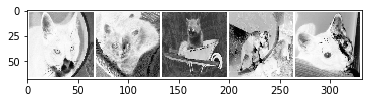

In [48]:
# show images
matplotlib_imshow(img_grid, one_channel=True)

In [49]:
# write to tensorboard
writer.add_image('five_dog_cat_images', img_grid)

In [50]:
#!tensorboard --logdir=runs

In [51]:
writer.add_graph(cnn2, X)
writer.close()

/home/aims/.local/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [53]:
for i, epoch in enumerate(range(100)):
    running_loss  = 0.0
    optimizer.zero_grad() #zero the parameter gradients
    output = cnn(X)
    
    loss = criterian(output, torch.max(target, 1)[1])
    
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    #print(epoch, ':', running_loss)
    
    if i % 10 == 9:
        writer.add_scalar('Train/Loss', running_loss / 10,
                            epoch * len(X) + i)
#writer.close()

/home/aims/.local/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
